<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting TMRM results with CDP-choline

<strong>Input Data:</strong>

`/012625-TMRM` 


<strong>Figures:</strong>

`fig4`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()

In [2]:
# load packages

from skimage import io
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import czifile
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
import pandas as pd
from datetime import datetime, timezone, timedelta
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

def get_metadata(czi_file_path):
    """
    Extract metadata information from a CZI file.

    Parameters:
    - czi_file_path (str): Path to the CZI file.

    Returns:
    - dict: Dictionary containing various metadata parameters.
    """
    # Open the CZI file
    with czifile.CziFile(czi_file_path) as czi:
        # Read the metadata from the CZI file
        metadata = czi.metadata()
        img = AICSImage(czi_file_path)
        root = ET.fromstring(metadata)

        RI = root.find(".//RefractiveIndex").text
        PinholeSizeAiry = root.find(".//PinholeSizeAiry").text    
        SizeX = root.find(".//SizeX").text
        SizeY = root.find(".//SizeY").text
        SizeZ = root.find(".//SizeZ").text
        SizeC = root.find(".//SizeC").text

        fluor = [x.text for x in root.findall('.//Fluor')]
        exwave = [x.text for x in root.findall('.//ExcitationWavelength')]
        emwave = [x.text for x in root.findall('.//EmissionWavelength')]
        #pinhole_diam = [x.text for x in root.findall('.//Position')]
        
        parameter_id = "MTBLSMPinholeDiameter"
        pinhole_diam = [x.text for x in root.findall(f'.//ParameterCollection[@Id="{parameter_id}"]/Position')]


        NA = [x.text for x in root.findall('.//NumericalAperture')]
        bits = [x.text for x in root.findall('.//BitsPerPixel')]
        time = [x.text for x in root.findall('.//AcquisitionDateAndTime')]
        intensity = [x.text for x in root.findall('.//Intensity')]

        DigitalGain = [x.text for x in root.findall('.//DigitalGain')]
        DigitalOffset = [x.text for x in root.findall('.//DigitalOffset')]

        TotalMagnification = [x.text for x in root.findall('.//TotalMagnification')]
        TotalAperture = [x.text for x in root.findall('.//TotalAperture')]

        LaserEnableTime = [x.text for x in root.findall('.//LaserEnableTime')]
        #ZStackSliceIndex = [x.text for x in root.findall('.//LineStep')]

        dictionary2 = dict({'RI': RI,
              'PinholeSizeAiry': PinholeSizeAiry,
              'SizeX': SizeX, 
              'SizeY': SizeY,
              'SizeZ': SizeZ,
              'SizeC': SizeC,
              'Fluor': fluor,
              'ExcitationWavelength': exwave,
              'EmissionWavelength': emwave,
              'MTBLSMPinholeDiameter': pinhole_diam,
              'NumericalAperture': NA,
              'BitsPerPixel': bits,
              'AcquisitionDateAndTime': time,
              'Intensity': intensity,
              'DigitalGain': DigitalGain,
              'DigitalOffset': DigitalOffset,
              'TotalMagnification': TotalMagnification,
              'TotalAperture': TotalAperture,
              'LaserEnableTime': LaserEnableTime,
              'pixelsize': img.physical_pixel_sizes})
        
        return dictionary2

def parse_iso_timestamp(ts):
    """Parse an ISO 8601 timestamp with extra fractional second digits."""
    # Remove the trailing 'Z' and store that we need UTC timezone.
    tz_utc = ts.endswith('Z')
    if tz_utc:
        ts = ts[:-1]  # Remove trailing 'Z'
    
    # Split on the decimal point to handle fractional seconds.
    if '.' in ts:
        date_part, frac_part = ts.split('.')
        # Truncate fractional part to 6 digits.
        frac_truncated = frac_part[:6]
        # Reassemble timestamp
        ts_fixed = f"{date_part}.{frac_truncated}"
    else:
        ts_fixed = ts
    
    # Parse the fixed string into a datetime object.
    dt = datetime.fromisoformat(ts_fixed)
    
    # If original string was in UTC (Z notation), set timezone to UTC.
    if tz_utc:
        dt = dt.replace(tzinfo=timezone.utc)
    
    return dt


def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)
    

def load_image(path):
    img = AICSImage(path)
    reshaped_img = img.data.reshape(30, 1024, 1024)
    return int_to_float(reshaped_img)

def align_image(fixed_image, moving_image):
    # Estimate shift
    shift, error, diffphase = phase_cross_correlation(fixed_image[0], moving_image[0])

    # Apply shift
    aligned_image = moving_image.copy()
    for x in range(moving_image.shape[0]):
        temp = fourier_shift(np.fft.fftn(moving_image[x]), shift)
        aligned_image[x] = np.fft.ifftn(temp).real
    return aligned_image


def return_non_unique_indices(df):
    """
    Identify and print non-unique indices in the columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.

    Returns:
    - temp: pandas DataFrame
        A DataFrame with unique values for each column.

    This function iterates through the columns of the input DataFrame and prints the column names
    where non-unique indices are found. It returns a DataFrame with unique values for each column.

    Example:
    return_non_unique_indices(my_dataframe)
    """
    res = []
    names = []
    for col in df.columns:
        try:
            r = df[col].unique()
        except TypeError:
            r = np.unique([str(x) for x in df[col]])
        res.append(r)
        names.append(col)
    temp = pd.DataFrame(res)
    temp.index = names
    non_unique_indices = temp.index[np.argwhere(np.array([np.sum([x!=None for x in temp.iloc[y]]) for y in range(temp.shape[0])])>1).reshape(-1)]
    print('\n'.join(non_unique_indices))
    return temp

def compute_time_difference(timestamp1, timestamp2):
    dt1 = parse_iso_timestamp(timestamp1)
    dt2 = parse_iso_timestamp(timestamp2)
    delta = dt2 - dt1
    return delta.total_seconds() / 60

def get_time_series(paths, line, well, parent):
    # align image
    all_ims = [load_image(f'{parent}/{x}') for x in paths]

    combined_image_before_alignment = all_ims[0][0] + all_ims[1][0] + all_ims[2][0]

    all_ims[1] = align_image(all_ims[0], all_ims[1])
    all_ims[2] = align_image(all_ims[0], all_ims[2])

    combined_image_after_alignment = all_ims[0][0] + all_ims[1][0] + all_ims[2][0]

    # get per-image metadata
    dictionaries = [get_metadata(f'{parent}/{x}') for x in paths]
    df = pd.DataFrame(dictionaries)
    print('The following metadata variables are NOT consistent across images:')
    temp = return_non_unique_indices(df)

    # get all time stamps
    L = df['AcquisitionDateAndTime'].to_list()
    all_times = [[parse_iso_timestamp(l[0]) + timedelta(seconds=x) for x in np.arange(0.0, 300.0, 10.0)] for l in L]

    # get binarized signal
    binarized_mask = all_ims[0][0].copy()
    binarized_mask[binarized_mask>np.percentile(binarized_mask, 75)] = 1
    binarized_mask[binarized_mask!=1] = 0


    plt.figure(figsize=(8, 5))
    plt.figure(figsize=(12, 4))

    # Show combined image before alignment
    plt.subplot(1, 3, 1)
    plt.imshow(combined_image_before_alignment)
    plt.title('Combined Image Before Alignment')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # Show combined image after alignment
    plt.subplot(1, 3, 2)
    plt.imshow(combined_image_after_alignment)
    plt.title('Combined Image After Alignment')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # Show binarized mask
    plt.subplot(1, 3, 3)
    plt.imshow(binarized_mask)
    plt.title('Binarized Mask')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # get mean intensity over time

    mean_masked_intensities = [[np.mean(im[x][binarized_mask==1]) for x in range(all_ims[0].shape[0])] for im in all_ims]
    df = pd.concat([pd.DataFrame(np.hstack(all_times)), pd.DataFrame(np.hstack(mean_masked_intensities))], axis=1)
    df.columns = ['time', 'intensity']
    conditions = [np.repeat(x, len(all_times[0])) for x in ['baseline', 'oligo', 'FPPC']]
    df['condition'] = np.hstack(conditions)
    df['minutes'] = [(x-df['time'][0]).total_seconds() / 60 for x in df['time']]
    df['line'] = line
    df['well'] = well
    non_mito = np.mean(df[df['condition']=='FPPC']['intensity'])
    df['intensity_norm'] = df['intensity']-non_mito
    return df

def load_image(path):
    img = AICSImage(path)
    return int_to_float(img.data[0][0][0])

import os

def list_files_in_folder(folder_path):
    return os.listdir(folder_path)


def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, pvalues):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.5, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.1, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(text_format='full', loc='outside',line_offset_to_group=10,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.set_custom_annotations(pvalues)
    annotator.annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax

from statannotations.Annotator import Annotator
def detect_outliers_iqr(data):
    # Compute the first and third quartiles
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Identify outliers
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

# plot separately (without FCCP) for main figure

def file_closest_to_median(df, condition_col="condition", target_col="value", file_col="files"):
    """
    For each group (specified by condition_col), this function computes the mean of target_col
    and returns a dictionary mapping each group to the file name (from file_col)
    that has a target_col value closest to that group's mean.
    """
    result = {}
    # Group by the condition column.
    for cond, group in df.groupby(condition_col):
        # Calculate the mean of the target column for this condition.
        mean_val = group[target_col].median()
        # Compute absolute differences from the mean.
        group = group.copy()  # Avoid SettingWithCopyWarning
        group["abs_diff"] = (group[target_col] - mean_val).abs()
        # Find the row index with the minimal difference.
        idx = group["abs_diff"].idxmin()
        # Get the corresponding file name.
        result[cond] = group.loc[idx, file_col]
    return result


Load the data

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_95979/971195825.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))


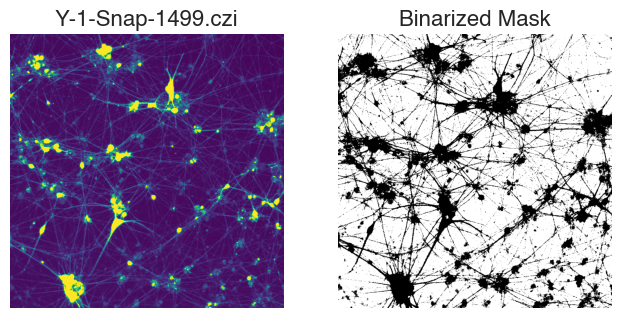

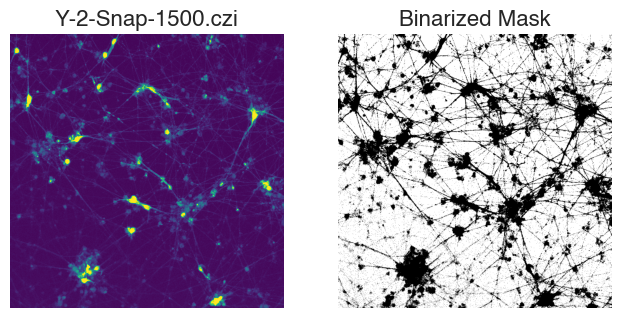

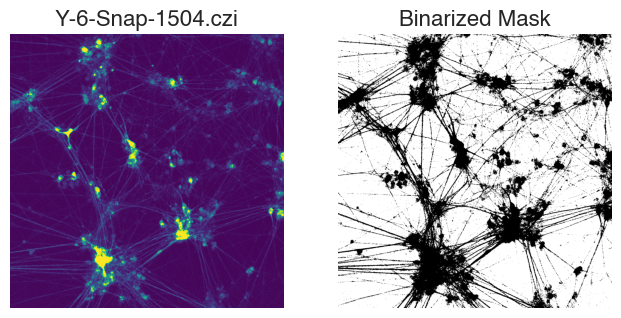

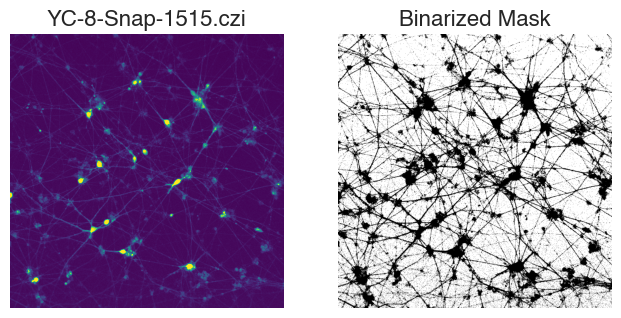

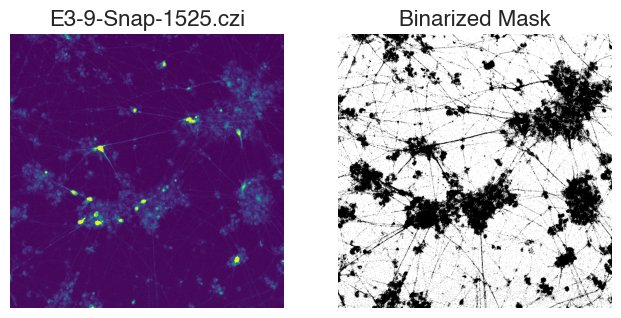

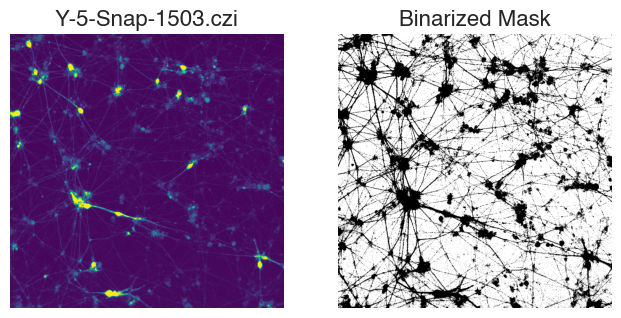

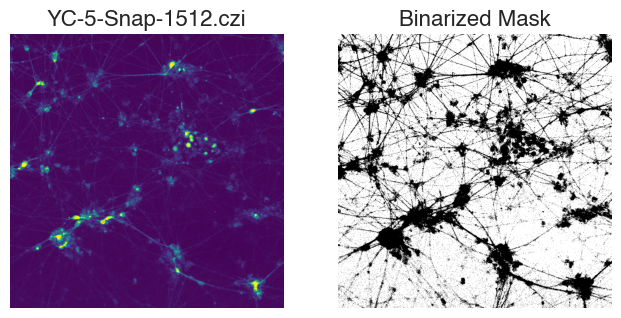

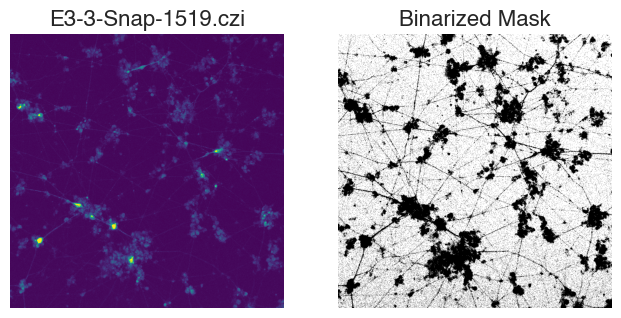

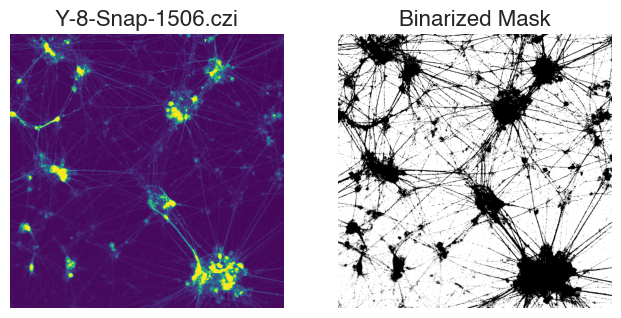

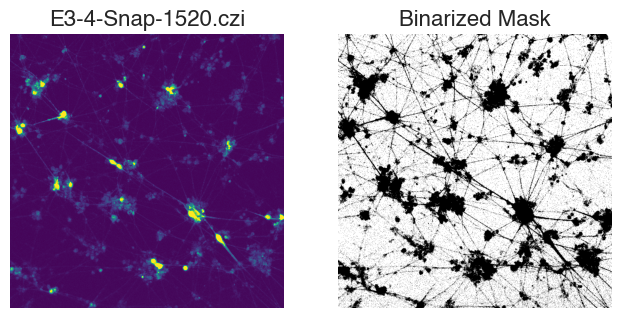

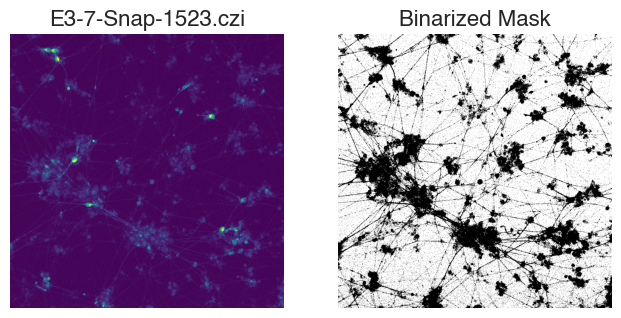

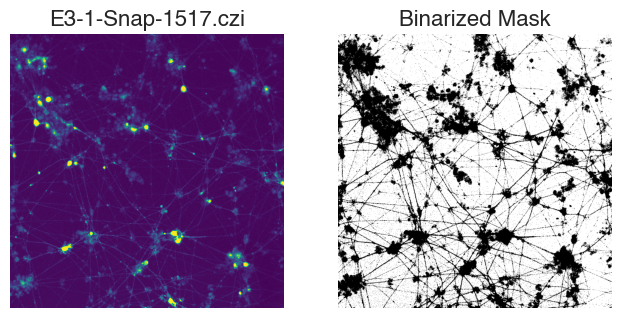

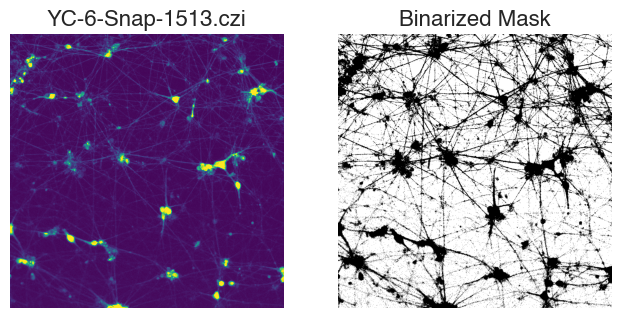

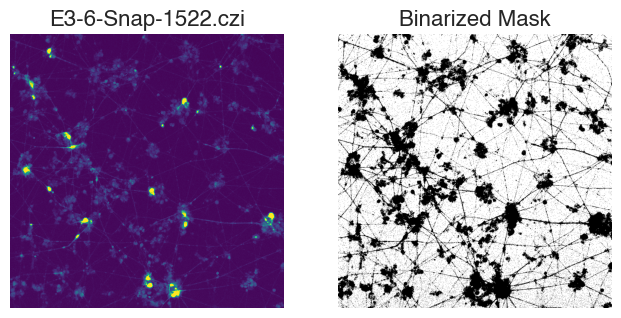

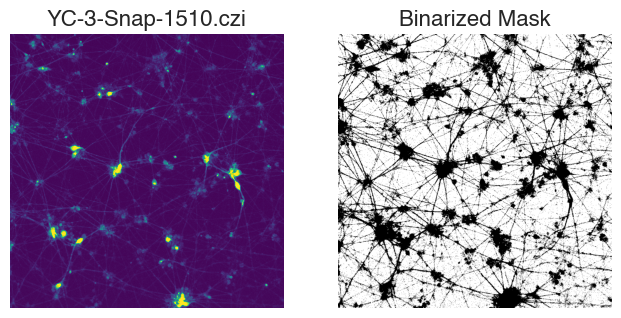

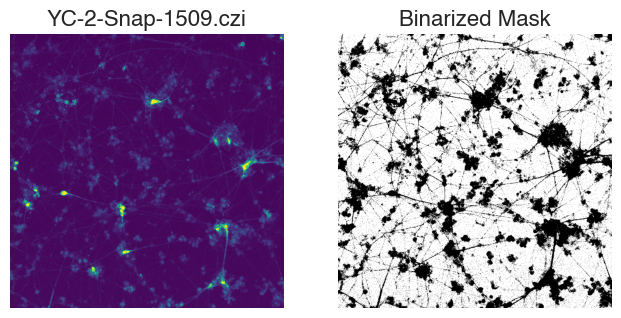

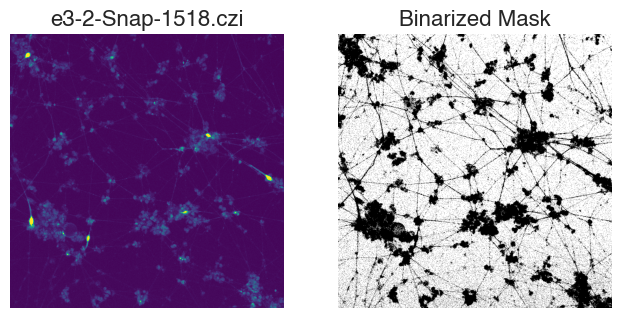

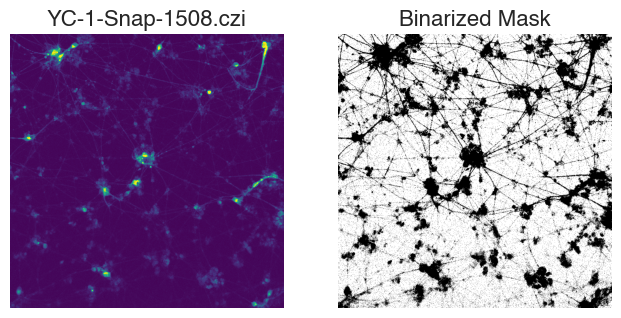

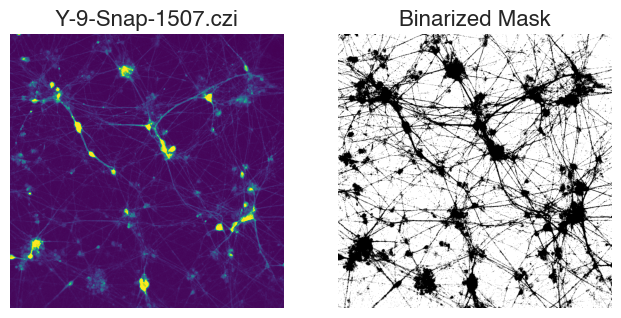

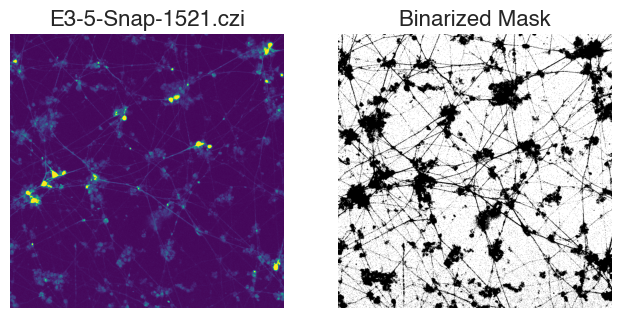

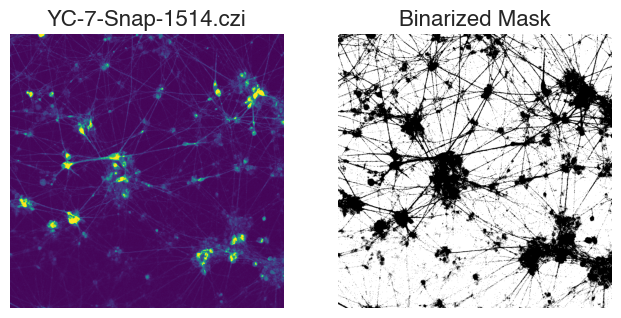

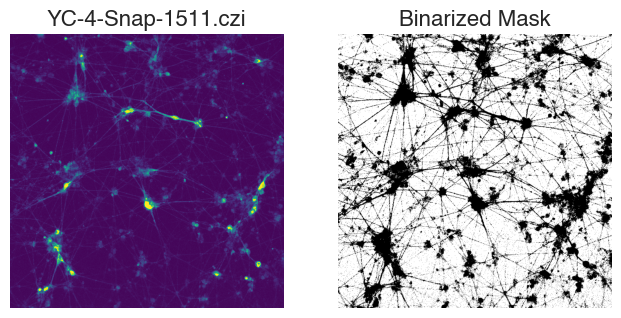

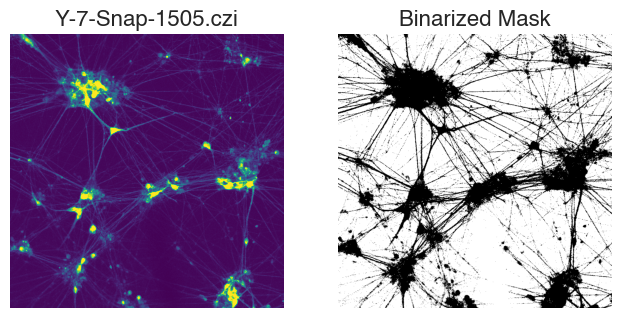

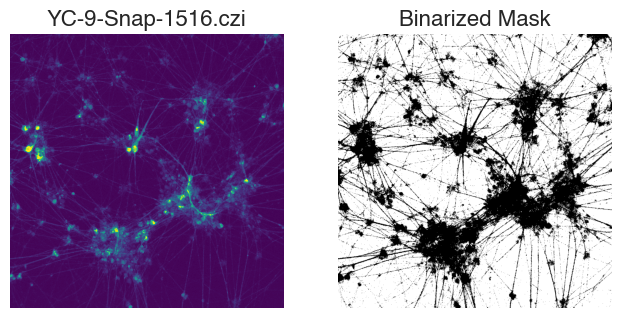

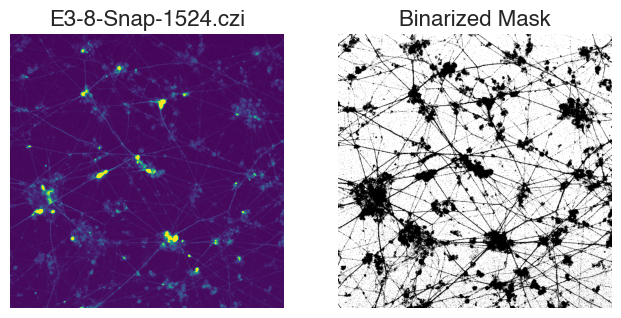

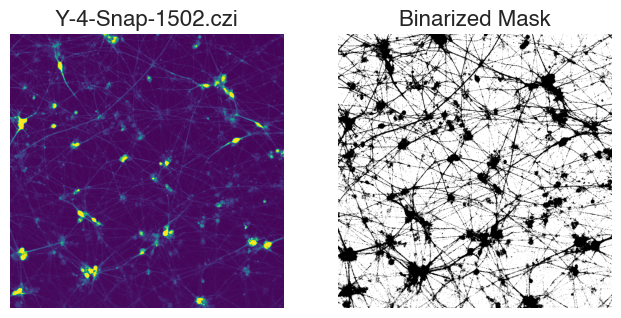

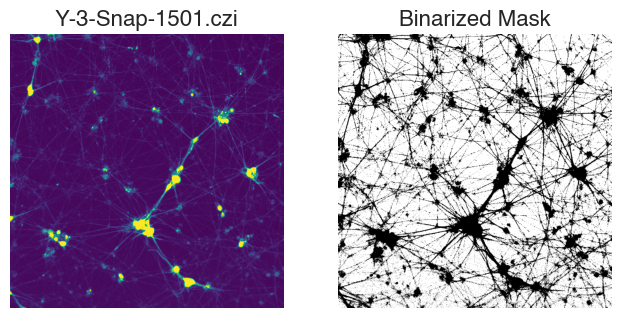

In [3]:
files = list_files_in_folder('../../imaging_data/012625-TMRM')
values = []
conditions = []
wells = []
for i in files:
    x = load_image(f'../../imaging_data/012625-TMRM/{i}')
    binarized_mask = x.copy()
    binarized_mask[binarized_mask>np.percentile(binarized_mask, 75)] = 1
    binarized_mask[binarized_mask!=1] = 0
    values.append(np.mean(x[binarized_mask==1]))
    conditions.append(i.split('-')[0].upper())
    wells.append(i.split('-')[1])

    plt.figure(figsize=(12, 4))
    # Show combined image after alignment
    plt.subplot(1, 3, 2)
    plt.imshow(x, cmap='viridis')
    plt.title(i)
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # Show binarized mask
    plt.subplot(1, 3, 3)
    plt.imshow(binarized_mask, cmap='gray_r')
    plt.title('Binarized Mask')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

# This batch also contains E3 with sig effect between E3 and Y

outlier removal

In [4]:
df = pd.DataFrame({'condition': conditions, 'well': wells, 'value': values})
df['files'] = files

# it's significant without outlier detection
outlier, _, _ = detect_outliers_iqr(df['value'].values)
df_temp = df[np.invert(outlier)]

print('the outlier would lead to even more significant results')
df[outlier]


the outlier would lead to even more significant results


condition well     value              files
0         Y    1  0.338016  Y-1-Snap-1499.czi

In [5]:
df_temp['condition'] = df_temp['condition'].astype(str)

file_closest_to_median(df_temp)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_95979/2918595563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['condition'] = df_temp['condition'].astype(str)


{'E3': 'E3-9-Snap-1525.czi',
 'Y': 'Y-4-Snap-1502.czi',
 'YC': 'YC-4-Snap-1511.czi'}

Do stats

In [6]:
from scipy.stats import shapiro, levene, ttest_ind

baseline_data = df_temp[df_temp['condition']!='E3']
group1 = baseline_data[baseline_data['condition'] == 'Y']['value']
group2 = baseline_data[baseline_data['condition'] == 'YC']['value']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
print('comparison: Y vs YC')
print(f'p-value for normality: {p_norm1}, {p_norm2}')

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(f'p-value for equal variances: {p_levene}')

comparison: Y vs YC
p-value for normality: 0.12251655059475741, 0.3153050954421514
p-value for equal variances: 0.6568255336917119


Plot the data

Y vs. YC: p=0.002


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_95979/3127533417.py:265: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


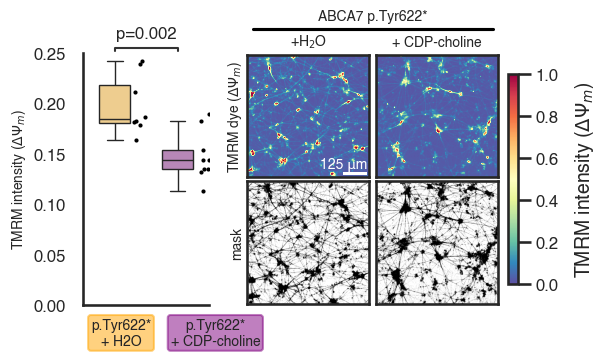

In [7]:
cmap = 'Spectral_r'
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

# Assuming your data and helper functions (e.g., load_image, plot_boxplot_by_treatment) are already defined
df_temp = df_temp[df_temp['condition']!='E3']

# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)
baseline_data = df_temp[df_temp['condition']!='E3']
group1 = baseline_data[baseline_data['condition'] == 'Y']['value']
group2 = baseline_data[baseline_data['condition'] == 'YC']['value']
t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value]]
ax_box = plot_boxplot_by_treatment(df_temp, 'condition', 'value', 
                                   order=[ 'Y', 'YC'], 
                                   pairs=[('Y', 'YC')],
                                   palette={'Y': 'orange', 'YC': 'purple'}, pvalues=formatted_pvalues)

ax_box.set_ylabel(r'TMRM intensity ($\Delta \Psi_m$)', fontsize=10)
ax_box.set_xticks([])

# Optionally add your custom x-axis labels to ax_box
# ax_box.text(0.5, -0.05, "WT + H2O", ha='center', va='top', 
#             transform=ax_box.get_xaxis_transform(),
#             bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), 
#             fontsize=10)
ax_box.text(0.1, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), 
            fontsize=10)
ax_box.text(1.6, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), 
            fontsize=10)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.set_ylim(0, 0.25)

# ------------------
# Right: Image panel with 2x2 subplots
# ------------------
# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 2, wspace=0.05, hspace=0.01)

# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])
img1 = load_image('../../imaging_data/012625-TMRM/Y-4-Snap-1502.czi')
# Process image if needed (e.g., create a binarized mask)
binarized_mask_y5 = img1.copy()
binarized_mask_y5[img1 > np.percentile(img1, 75)] = 1
binarized_mask_y5[img1 <= np.percentile(img1, 75)] = 0

ax_img1.imshow(img1, vmin=0, vmax=1, cmap=cmap)
ax_img1.set_title('+H$_2$O', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])

# Top right image
ax_img2 = fig.add_subplot(gs_right[0, 1])
img2 = load_image('../../imaging_data/012625-TMRM/YC-4-Snap-1511.czi')#YC-4-Snap-1511.czi')
ax_img2.imshow(img2, vmin=0, vmax=1, cmap=cmap)
ax_img2.set_title('+ CDP-choline', fontsize=10)
ax_img2.set_xticks([])
ax_img2.set_yticks([])

# Bottom left image
ax_img3 = fig.add_subplot(gs_right[1, 0])
ax_img3.imshow(binarized_mask_y5, cmap='gray_r')
ax_img3.set_xticks([])
ax_img3.set_yticks([])


# Bottom right image
ax_img4 = fig.add_subplot(gs_right[1, 1])
# For demonstration, we reuse binarized_mask_y5 or load another image if available.
# Replace with your intended image (e.g., binarized_mask_yc3) as needed.
img3 = load_image('../../imaging_data/012625-TMRM/YC-4-Snap-1511.czi')
binarized_mask_yc3 = img3.copy()
binarized_mask_yc3[img3 > np.percentile(img3, 75)] = 1
binarized_mask_yc3[img3 <= np.percentile(img3, 75)] = 0
ax_img4.imshow(binarized_mask_yc3, cmap='gray_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])

ax_img1.set_ylabel(r'TMRM dye ($\Delta \Psi_m$)', rotation=90, fontsize=10, labelpad=2)
ax_img3.set_ylabel('mask', rotation=90, fontsize=10, labelpad=2)

# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'TMRM intensity ($\Delta \Psi_m$)', labelpad=10)

# ------------------
# Final adjustments and save
# ------------------
#fig.suptitle('ABCA7 p.Tyr622*', fontsize=10, y=1.)  # Title spanning both panels

# Add single bar and title spanning both columns
fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# Add vertical bar above spanning both columns
bar_width = 5
bar_y = 1
fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))


plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = binarized_mask_y5.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img1.add_patch(scale_bar)

img = AICSImage('../../imaging_data/030625-Cellrox/Y-9-Snap-1997.czi')
# Add a text label above the scale bar (centered)
ax_img1.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)


plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/tmrm_choline.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
df_temp['condition'].value_counts()

condition
YC    9
Y     8
Name: count, dtype: int64